In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
def load_data(filename, delimiter):
    """
    Loads the data from csv file to a dataframe.
    """
    if os.path.isfile(filename):
        df = pd.read_csv(filename, delimiter=delimiter)
        return df
    else:
        print("File not found")
        return None


In [4]:
df = load_data('../../data/testset_C.csv', ';')

### Modeling and experiments (single model)

We considered the Product Category prediction problem as a multiclass text classiication problem. 

Initially for data preprocessing, we split the given dataset into training and test datasets. We considered 'productgroup' as target feature for classification whereas the rest of the features were used as a combination of training features such as 'merged_text feature was created by merging the 'main_text' and 'add_text' features. We applied TF-IDF vectorization to the textual features to numerize them. 

For model building, we built Logistic Regression, Decision Tree, Random Forest, Perceptron, Multi-layer Perceptron, and Gradient Boosting models to classify a given text into its category.

For model evaluation, we performed Repeated Stratified 10 fold cross validation on the training set to see whether the model overfits or not by comparing the training and validation accuracy. Repeated Stratified K-Folds technique repeats Stratified K-Fold sets n times with different randomization in each repetition. StratifiedKFold is a variation of k-fold which returns stratified folds where each set contains approximately the same percentage of samples of each target class as the complete set. For test set evaluation, we measured the test accuracy, test precision, recall, and test F1-score of each models respectively. We also plot the confusion matrix for each ml model implemented to solve the problem.

At first, we just do step-by-step modeling, training, and evalaution for a single model on the 'merged_text' field. Later, we automate the pipeline to run for various models by defining methods for data preprocessing, modelling, training, evaluation, and testing.

In [5]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn import metrics
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer


In [6]:
print('Shape of the dataset', df.shape)

Shape of the dataset (8000, 5)


In [7]:
# dropping NaN values from the dataframe
df = df.dropna()
print('Shape of the dataframe after dropping NaN values', df.shape)

Shape of the dataframe after dropping NaN values (6655, 5)


In [8]:
# merging the text features into one 'merged_text'
df['merged_text'] = df[['main_text', 'add_text', 'manufacturer']].apply(lambda x: ' '.join(x), axis=1)

In [9]:
from sklearn.compose import make_column_transformer
# considering the 'merged_text' as an input feature which is a combination of main_text, add_text, and manufacturer
vect = TfidfVectorizer()
transformer = make_column_transformer((vect, 'merged_text'))
# transformer = make_column_transformer((vect, 'main_text'), (vect, 'add_text'), (vect, 'manufacturer'))

In [10]:
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score

In [11]:
# defining the single classifier model and pipelining the tranformation of the input features
clf = MultinomialNB(alpha=.01)
pipe = make_pipeline(transformer, clf)

In [12]:
# pipeline module used for preprocessing and training simultaneously
pipe

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('tfidfvectorizer',
                                                  TfidfVectorizer(),
                                                  'merged_text')])),
                ('multinomialnb', MultinomialNB(alpha=0.01))])

In [13]:
# Defining the feature columns for training 
#feature_cols = ['main_text', 'add_text', 'manufacturer']
feature_cols = ['merged_text']

X = df[feature_cols]
y = df['productgroup']

In [14]:
# Shape of the input feature matrix for training
print(X.shape)
print(y.shape)

(6655, 1)
(6655,)


In [15]:
# Splitting the dataset into training and test sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [16]:
# Shape of the training and test set
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(5324, 1)
(1331, 1)
(5324,)
(1331,)


In [17]:
# test dataset
X_test.head()

,merged_text
4456,ACUVUE OASYS FOR ASTIGMATISM6 STÜCKUNISEX LINS...
3404,"WASCHVOLLAUTOMAT OMV510A+ OMV510A+|| EEK:A+, 1..."
858,KINGSTON DATATRAVELER MICRO 3.1 64GB - USB-STI...
4265,AIR OPTIX FOR ASTIGM.6 STÜCKUNISEX LINSEN CIBA
3041,DATATRAVELERMICRODUO/64GB MICRO USB3 OTG PERIP...


In [18]:
# fitting the model on the training data
pipe.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('tfidfvectorizer',
                                                  TfidfVectorizer(),
                                                  'merged_text')])),
                ('multinomialnb', MultinomialNB(alpha=0.01))])

In [19]:
# with only merged_text
cross_val_score(pipe, X_train, y_train, cv=10, scoring='accuracy').mean()

0.999060855703988

In [20]:
from sklearn.model_selection import RepeatedStratifiedKFold, cross_validate
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
scores = cross_validate(pipe, X_train, y_train, scoring=('accuracy', 'f1_weighted'),
                            cv=cv, n_jobs=-1, return_train_score=True)

In [21]:
# with only merged_text
scores

{'fit_time': array([0.32042909, 0.25716472, 0.27864575, 0.26173878, 0.24724412,
        0.25602722, 0.36150479, 0.40358901, 0.2651732 , 0.24730301,
        0.23954678, 0.25264359, 0.28212881, 0.27344847, 0.24409652,
        0.2607367 , 0.37559271, 0.35077119, 0.32500339, 0.36702561,
        0.27525067, 0.2803731 , 0.2515471 , 0.23496032, 0.26190591,
        0.17267823, 0.2481792 , 0.18242931, 0.23667407, 0.23267269]),
 'score_time': array([0.03221822, 0.0318954 , 0.03506756, 0.03736877, 0.03377151,
        0.03420758, 0.03511453, 0.04764557, 0.03283834, 0.03261113,
        0.03006768, 0.03595233, 0.03578496, 0.03981495, 0.04020095,
        0.10253024, 0.04585648, 0.03869629, 0.0341773 , 0.04162335,
        0.03353643, 0.03443217, 0.03303909, 0.03179288, 0.0316534 ,
        0.02189016, 0.03185272, 0.0241003 , 0.0318923 , 0.03225517]),
 'test_accuracy': array([0.99812383, 1.        , 1.        , 0.99812383, 1.        ,
        1.        , 1.        , 1.        , 1.        , 0.9962406 ,
 

#### Testing

In [22]:
from sklearn.metrics import precision_recall_fscore_support
y_test_pred = pipe.predict(X_test)
test_acc = metrics.accuracy_score(y_test_pred, y_test)
test_p, test_r, test_f1, _ = precision_recall_fscore_support(y_test, y_test_pred, average='weighted')

In [23]:
print(y_test_pred)
print(y_test)

['CONTACT LENSES' 'WASHINGMACHINES' 'USB MEMORY' ... 'WASHINGMACHINES'
 'BICYCLES' 'USB MEMORY']
4456     CONTACT LENSES
3404    WASHINGMACHINES
858          USB MEMORY
4265     CONTACT LENSES
3041         USB MEMORY
             ...       
283          USB MEMORY
7743    WASHINGMACHINES
5246    WASHINGMACHINES
3506           BICYCLES
6502         USB MEMORY
Name: productgroup, Length: 1331, dtype: object


In [24]:
# with only 'merged_text'
print("Test Accuracy", test_acc)
print("Test Precision", test_p)
print("Test Recall", test_r)
print("Test F1", test_f1)

Test Accuracy 1.0
Test Precision 1.0
Test Recall 1.0
Test F1 1.0


In [25]:
print(metrics.classification_report(y_test, y_test_pred))

                 precision    recall  f1-score   support

       BICYCLES       1.00      1.00      1.00       321
 CONTACT LENSES       1.00      1.00      1.00       364
     USB MEMORY       1.00      1.00      1.00       350
WASHINGMACHINES       1.00      1.00      1.00       296

       accuracy                           1.00      1331
      macro avg       1.00      1.00      1.00      1331
   weighted avg       1.00      1.00      1.00      1331



In [26]:
new_text = '8GB 2.0 RED '
df_test_on_go = pd.DataFrame({'merged_text': new_text}, index=[0])
print(pipe.predict(df_test_on_go))

['USB MEMORY']


In [27]:
from sklearn.preprocessing import LabelEncoder
# encoding the target variable
def encode_targets(y_train, y_test):
    le = LabelEncoder()
    le.fit(y_train)
    y_train_enc = le.transform(y_train)
    y_test_enc = le.transform(y_test)
    
    return y_train_enc, y_test_enc

## Modeling, training, evaluation and pipeling the experiments for various classification models

### Data Preprocessing for training

In [28]:
from sklearn.model_selection import train_test_split
def preprocess_dataset(input_data):
    """ The preprocessing selects the relevant data.

    :param input_data: Input data
    :return X: Transformed data containing the training data.
    :rtype: .... """
    
    feature_cols = ['merged_text']
    input_data = input_data[['productgroup', 'main_text', 'add_text']].dropna()
    input_data['merged_text'] = input_data[['main_text', 'add_text']].apply(lambda x: ' '.join(x), axis=1)
    print(input_data.columns)
    print("Input dataframe shape", input_data.shape)

    X = input_data[feature_cols]
    # Putting response variable to y
    y = input_data['productgroup']
    # Splitting the data into train and test
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8,
                                                        test_size=0.2, random_state=100)

    return X_train, y_train, X_test, y_test

In [29]:
def transform_data():
    """
    Transforming into TF-IDF vectorization of the input data
    """
    vect = TfidfVectorizer()
    transformer = make_column_transformer((vect, 'merged_text'))
    return vect, transformer

### Modeling

In [30]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression, Perceptron, PoissonRegressor
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.compose import make_column_transformer
from sklearn.feature_extraction.text import TfidfVectorizer

def get_ml_models():
    """
    ML model to be trained.
    """
    models = dict()
    vect, transformer = transform_data()
    # Logistic regression
    model = LogisticRegression()
    models['LR'] = Pipeline(steps=[('feature_transform', transformer), ('m', model)])

    # Multinomial Naive Bayes
    model = MultinomialNB(alpha=.01)
    models['MultiNaiveBayes'] = Pipeline(steps=[('feature_transform', transformer), ('m', model)])

    # Perceptron
    model = Perceptron()
    models['Perceptron'] = Pipeline(steps=[('feature_transform', transformer), ('m', model)])

    # Decision Tree
    model = DecisionTreeClassifier()
    models['CART'] = Pipeline(steps=[('feature_transform', transformer), ('m', model)])

    # Random Forest
    model = RandomForestClassifier()
    models['RandomForest'] = Pipeline(steps=[('feature_transform', transformer), ('m', model)])

    # Multilayer Perceptron
    model = MLPClassifier(random_state=1, early_stopping=True)
    models['MLP'] = Pipeline(steps=[('feature_transform', transformer), ('m', model)])

    return models

#### Evaluation: Cross Validation and Test Predictions

In [31]:
from sklearn import metrics
from sklearn.metrics import precision_recall_fscore_support
from sklearn.model_selection import RepeatedStratifiedKFold, cross_validate

def evaluate_model_predict(model, X, y, X_test, y_test):
    """
    Performs the cross validation of the ML algorithms and returns the training,
     validation scores, and test predictions.
    """
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    model.fit(X, y)
    # cross validation
    scores = cross_validate(model, X, y, scoring=('accuracy', 'f1_weighted'),
                            cv=cv, n_jobs=-1, return_train_score=True)
    # test prediction from the trained ml model
    y_test_pred = model.predict(X_test)

    # test metrics like accuracy, precision, recall, f1-score
    test_acc = metrics.accuracy_score(y_test_pred, y_test)
    test_p, test_r, test_f1, _ = precision_recall_fscore_support(y_test, y_test_pred, average='weighted')

    return scores, y_test_pred, test_acc, test_p, test_r, test_f1

In [32]:
from numpy import mean, std
from sklearn.metrics import ConfusionMatrixDisplay
import time

def batch_prediction(X_train, y_train, X_test, y_test, models):
    """
    Finding the predictions for each model on the dataset by calling the evaluate_model()
    """
    #  the models and store results
    results, names = list(), list()
    # test prediction list for all models
    test_preds = []

    for name, model in models.items():
        t0 = time.time()
        # prediction and evaluation scores for each model
        scores, y_test_pred, test_acc, test_p, test_r, test_f1 = evaluate_model_predict(model, X_train, y_train,
                                                                                X_test, y_test)
        time2complete = time.time() - t0
        print("Time to train and eval for the model %s is %.3f"
              % (name, time2complete))
        # appending the test prediction of the respective model
        test_preds.append((model, y_test_pred))
        # appending the evaluation scores
        results.append(scores)
        # appending the names of the model
        names.append(name)
        # printing the training accuracy
        print('Average Training accuracy for %s is %.3f (%.3f)'
              % (name, mean(scores['train_accuracy'])*100,
                 std(scores['train_accuracy'])))

        # printing the validation accuracy
        print('Average Validation accuracy for %s is %.3f (%.3f)'
              % (name, mean(scores['test_accuracy'])*100,
                 std(scores['test_accuracy'])))
        # printing thr training F1-score
        print('Average Training F1 score for %s is %.3f (%.3f)'
              % (name, mean(scores['train_f1_weighted']),
                 std(scores['train_f1_weighted'])))
        # printing the validation F1-score
        print('Average Validation F1-score for %s is %.3f (%.3f)'
              % (name, mean(scores['test_f1_weighted']),
                 std(scores['test_f1_weighted'])))
        # printing the test accuracy of a model
        print('Test accuracy for %s is %.3f' % (name, test_acc*100))
        # printing the test precision of a model
        print('Test Precision for %s is %f' % (name, test_p))
        # printing the test recall of a model
        print('Test Recall for %s is %.3f' % (name, test_r))
        # printing the test F1-score of a model
        print('Test F1-score for %s is %.3f' % (name, test_f1))
        #metrics.plot_roc_curve(model, X_test, y_test)
        #plt.show()
        print(metrics.classification_report(y_test, y_test_pred))
        cm = metrics.confusion_matrix(y_test, y_test_pred)
        cm_display = ConfusionMatrixDisplay(cm).plot()
        plt.show()
        print('-------------------------------------------------')

Index(['productgroup', 'main_text', 'add_text', 'merged_text'], dtype='object')
Input dataframe shape (7998, 4)
Time to train and eval for the model LR is 9.560
Average Training accuracy for LR is 99.969 (0.000)
Average Validation accuracy for LR is 99.755 (0.002)
Average Training F1 score for LR is 1.000 (0.000)
Average Validation F1-score for LR is 0.998 (0.002)
Test accuracy for LR is 99.625
Test Precision for LR is 0.996290
Test Recall for LR is 0.996
Test F1-score for LR is 0.996
                 precision    recall  f1-score   support

       BICYCLES       1.00      1.00      1.00       395
 CONTACT LENSES       1.00      0.99      1.00       378
     USB MEMORY       1.00      0.99      1.00       430
WASHINGMACHINES       0.99      1.00      0.99       397

       accuracy                           1.00      1600
      macro avg       1.00      1.00      1.00      1600
   weighted avg       1.00      1.00      1.00      1600



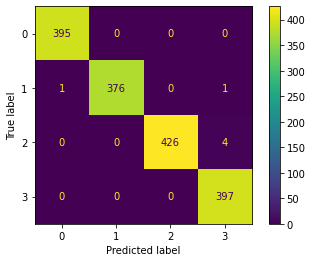

-------------------------------------------------
Time to train and eval for the model MultiNaiveBayes is 2.827
Average Training accuracy for MultiNaiveBayes is 100.000 (0.000)
Average Validation accuracy for MultiNaiveBayes is 99.802 (0.002)
Average Training F1 score for MultiNaiveBayes is 1.000 (0.000)
Average Validation F1-score for MultiNaiveBayes is 0.998 (0.002)
Test accuracy for MultiNaiveBayes is 99.688
Test Precision for MultiNaiveBayes is 0.996877
Test Recall for MultiNaiveBayes is 0.997
Test F1-score for MultiNaiveBayes is 0.997
                 precision    recall  f1-score   support

       BICYCLES       1.00      1.00      1.00       395
 CONTACT LENSES       0.99      0.99      0.99       378
     USB MEMORY       1.00      1.00      1.00       430
WASHINGMACHINES       0.99      1.00      1.00       397

       accuracy                           1.00      1600
      macro avg       1.00      1.00      1.00      1600
   weighted avg       1.00      1.00      1.00      1

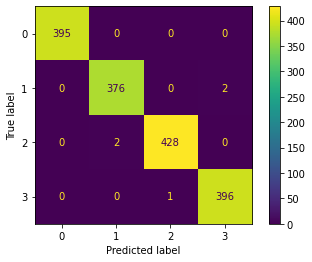

-------------------------------------------------
Time to train and eval for the model Perceptron is 2.845
Average Training accuracy for Perceptron is 100.000 (0.000)
Average Validation accuracy for Perceptron is 99.656 (0.003)
Average Training F1 score for Perceptron is 1.000 (0.000)
Average Validation F1-score for Perceptron is 0.997 (0.003)
Test accuracy for Perceptron is 99.688
Test Precision for Perceptron is 0.996895
Test Recall for Perceptron is 0.997
Test F1-score for Perceptron is 0.997
                 precision    recall  f1-score   support

       BICYCLES       1.00      1.00      1.00       395
 CONTACT LENSES       1.00      1.00      1.00       378
     USB MEMORY       1.00      0.99      1.00       430
WASHINGMACHINES       0.99      1.00      0.99       397

       accuracy                           1.00      1600
      macro avg       1.00      1.00      1.00      1600
   weighted avg       1.00      1.00      1.00      1600



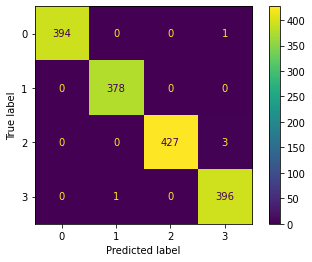

-------------------------------------------------
Time to train and eval for the model CART is 4.133
Average Training accuracy for CART is 100.000 (0.000)
Average Validation accuracy for CART is 98.369 (0.004)
Average Training F1 score for CART is 1.000 (0.000)
Average Validation F1-score for CART is 0.984 (0.004)
Test accuracy for CART is 99.062
Test Precision for CART is 0.990860
Test Recall for CART is 0.991
Test F1-score for CART is 0.991
                 precision    recall  f1-score   support

       BICYCLES       1.00      0.98      0.99       395
 CONTACT LENSES       0.99      0.99      0.99       378
     USB MEMORY       1.00      0.99      0.99       430
WASHINGMACHINES       0.97      1.00      0.98       397

       accuracy                           0.99      1600
      macro avg       0.99      0.99      0.99      1600
   weighted avg       0.99      0.99      0.99      1600



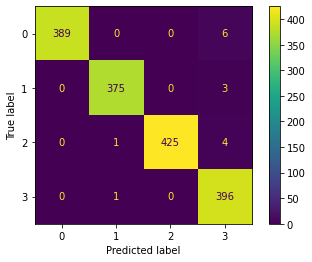

-------------------------------------------------
Time to train and eval for the model RandomForest is 14.502
Average Training accuracy for RandomForest is 100.000 (0.000)
Average Validation accuracy for RandomForest is 99.406 (0.003)
Average Training F1 score for RandomForest is 1.000 (0.000)
Average Validation F1-score for RandomForest is 0.994 (0.003)
Test accuracy for RandomForest is 99.500
Test Precision for RandomForest is 0.995099
Test Recall for RandomForest is 0.995
Test F1-score for RandomForest is 0.995
                 precision    recall  f1-score   support

       BICYCLES       1.00      0.99      1.00       395
 CONTACT LENSES       1.00      1.00      1.00       378
     USB MEMORY       1.00      0.99      1.00       430
WASHINGMACHINES       0.98      1.00      0.99       397

       accuracy                           0.99      1600
      macro avg       1.00      1.00      1.00      1600
   weighted avg       1.00      0.99      1.00      1600



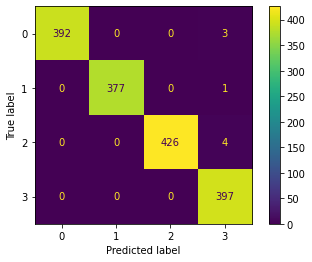

-------------------------------------------------
Time to train and eval for the model MLP is 174.814
Average Training accuracy for MLP is 99.969 (0.000)
Average Validation accuracy for MLP is 99.812 (0.002)
Average Training F1 score for MLP is 1.000 (0.000)
Average Validation F1-score for MLP is 0.998 (0.002)
Test accuracy for MLP is 99.812
Test Precision for MLP is 0.998127
Test Recall for MLP is 0.998
Test F1-score for MLP is 0.998
                 precision    recall  f1-score   support

       BICYCLES       1.00      1.00      1.00       395
 CONTACT LENSES       1.00      1.00      1.00       378
     USB MEMORY       1.00      1.00      1.00       430
WASHINGMACHINES       0.99      1.00      1.00       397

       accuracy                           1.00      1600
      macro avg       1.00      1.00      1.00      1600
   weighted avg       1.00      1.00      1.00      1600



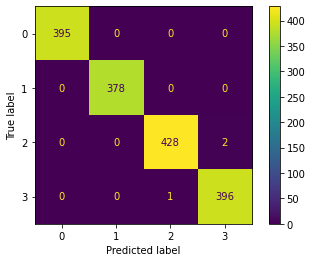

-------------------------------------------------


In [35]:
def main():
    input_data = load_data('../../data/testset_C.csv', delimiter=';')
    X_train, y_train, X_test, y_test = preprocess_dataset(input_data)
    # getting all the implemented ml models
    models = get_ml_models()
    # getting the predictions for both the training and testing datasets
    batch_prediction(X_train, y_train, X_test, y_test, models)


if __name__ == "__main__":
    main()

| Model               | Training Accuracy | Validation Accuracy | Test Accuracy | Test Precision | Test Recall | Test F1-Score | Training F1-score | Validation F1-score | Time to train and evaluate |
|---------------------|-------------------|---------------------|---------------|----------------|-------------|---------------|-------------------|---------------------|------------|
| Logistic Regression | 99.969            | 99.755              | 99.625        | 0.99629       | 0.996       | 0.996         | 1.0             | 0.998 | 9.157
| Multinomial Naive Bayes | 100            | 99.802              | 99.688        | 0.996877       | 0.997       | 0.997         | 1.0             | 0.998 | 2.981 
| Perceptron  |  100       | 99.656            | 99.688              | 0.996895        | 0.997       | 0.997       | 1.0   | 0.997 | 3.320
| CART                | 100           | 98.296              | 99.125        | 0.991449       | 0.991       | 0.991         | 1.000             | 0.983 | 4.917 |
| Random Forest | 100           | 99.380              | 99.500        | 0.995099       | 0.995       | 0.995         | 1.000             | 0.994 | 14.784 
| MLP                 | 99.969            | **99.812**              | **99.812**        | 0.998127       | 0.998       | **0.998**         | 1.0             | **0.998** | 165.513 

We propose MLP model as the best model. We observed that the decision tree (CART) has resulted in the lowest test accuracy and test f1-score among all the models and it also seems like its going to overfit slightly on the data due to higher training accuracy than the test and the validation accuracy respectively. We see that all the classifiers have worked pretty well mostly due to the quality of data as the 4 labels are almost equally balanced throughout the dataset.